In [1]:
import os
import json
import wandb
import random
import argparse
import itertools
import numpy as np
from time import gmtime, strftime

import soundfile as sf

import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('../training')
sys.path.append('../training/networks/nansypp')
sys.path.append('../testing')
from hifigan.generator import HifiganGenerator
from hifigan.vctk_loader import VCTK_dataset, LogMelSpectrogram

from datasets.loader import Dataset
from networks.discriminator import Discriminator
from networks.f2v import F2V_Ecapa
from nansypp import Nansypp
from hyface import Nansy, BShall_Nimbre, BShall_Ecapa
# import loss_funcs

from utils import audio_utils
from utils.data_utils import phoneme_inventory, decollate_tensor, combine_fixed_length
from utils import utils

import IPython.display as ipd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
from PIL import Image as PILImage
import matplotlib.pyplot as plt
cmap = np.array(plt.get_cmap('viridis').colors)

# Setting

## Argument setting

In [3]:
# main_dir = '/home/jaejun/nansy/
config_path = '/disk3/jaejun/hyface/bshall_ecapa/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
# args.base_dir = '/home/jaejun/temp_jaejun/hyface/230810/checkpoints'

# Data

In [153]:
# trainset = Dataset(args, meta_root=os.path.join(args.meta_root, 'filelists'),
#                         mode='train', datasets=['vctk'], sample_rate=args.data.sample_rate)
# testset = Dataset(args, meta_root=os.path.join(args.meta_root, 'filelists'),
#                         mode='test', datasets=['vctk'], sample_rate=args.data.sample_rate)
# print(f'train:{len(trainset)},test:{len(testset)}')
# train_loader = DataLoader(trainset, batch_size=4, collate_fn=trainset.collate, shuffle=True)
# test_loader = DataLoader(testset, batch_size=4, collate_fn=testset.collate)

In [22]:
# trainset = Dataset(args, meta_root=os.path.join(args.meta_root, 'filelists'),
#                         mode='VoxC', datasets=['vctk'], sample_rate=args.data.sample_rate)

In [23]:
# batch = next(iter(train_loader))
# audio = batch['audio']
# ling = batch['hubert']
# print(audio.shape, ling.shape)

In [24]:
# ipd.Audio(audio[0], rate=16000)

In [25]:
# batch = next(iter(train_loader))
# audio = batch['audio']
# ling = batch['hubert']
# print(audio.shape, ling.shape)

## VCTK

In [113]:
vctk_dir = '/disk2/vctk/modified/wav16_cleaned'
vctk_spkrs = os.listdir(vctk_dir)
print(len(vctk_spkrs))

108


### Female 1

In [114]:
vctk_f1_spk = 'p225'
vctk_f1_file = 'p225_001.wav'
vctk_f1_path = os.path.join(vctk_dir, vctk_f1_spk, vctk_f1_file)
vctk_f1, sr = torchaudio.load(vctk_f1_path)
print(vctk_f1.shape, sr)
ipd.Audio(vctk_f1, rate=16000)

torch.Size([1, 32825]) 16000


ecapa

In [115]:
files = os.listdir(os.path.join(vctk_dir, vctk_f1_spk))
vctk_f1_ecapas = []
for file in files:
    temp_file = torch.load(os.path.join(vctk_dir, vctk_f1_spk, file).replace('wav16_cleaned','ecapa').replace('.wav','.emb'))
    vctk_f1_ecapas.append(temp_file)
vctk_f1_ecapas = torch.vstack(vctk_f1_ecapas)
vctk_f1_ecapa_avg = torch.mean(vctk_f1_ecapas, axis=0).unsqueeze(0)
print(vctk_f1_ecapas.shape, vctk_f1_ecapa_avg.shape)

torch.Size([231, 192]) torch.Size([1, 192])


nimbre

In [61]:
files = os.listdir(os.path.join(vctk_dir, vctk_f1_spk))
vctk_f1_nimbre_globals = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_f1_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
    vctk_f1_nimbre_globals.append(temp_file)
vctk_f1_nimbre_globals = torch.vstack(vctk_f1_nimbre_globals)
vctk_f1_nimbre_global_avg = torch.mean(vctk_f1_nimbre_globals, axis=0).unsqueeze(0)
print(vctk_f1_nimbre_globals.shape, vctk_f1_nimbre_global_avg.shape)

files = os.listdir(os.path.join(vctk_dir, vctk_f1_spk))
vctk_f1_nimbre_banks = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_f1_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
    vctk_f1_nimbre_banks.append(temp_file.unsqueeze(0))
vctk_f1_nimbre_banks = torch.vstack(vctk_f1_nimbre_banks)
vctk_f1_nimbre_bank_avg = torch.mean(vctk_f1_nimbre_banks, axis=0).unsqueeze(0)
print(vctk_f1_nimbre_banks.shape, vctk_f1_nimbre_bank_avg.shape)

torch.Size([231, 192]) torch.Size([1, 192])
torch.Size([231, 128, 50]) torch.Size([1, 128, 50])


### Female 2

In [62]:
vctk_f2_spk = 'p238'
vctk_f2_file = 'p238_003.wav'
vctk_f2_path = os.path.join(vctk_dir, vctk_f2_spk, vctk_f2_file)
vctk_f2, sr = torchaudio.load(vctk_f2_path)
print(vctk_f2.shape, sr)
ipd.Audio(vctk_f2, rate=16000)

torch.Size([1, 133150]) 16000


ecapa

In [63]:
files = os.listdir(os.path.join(vctk_dir, vctk_f2_spk))
vctk_f2_ecapas = []
for file in files:
    temp_file = torch.load(os.path.join(vctk_dir, vctk_f2_spk, file).replace('wav16_cleaned','ecapa').replace('.wav','.emb'))
    vctk_f2_ecapas.append(temp_file)
vctk_f2_ecapas = torch.vstack(vctk_f2_ecapas)
vctk_f2_ecapa_avg = torch.mean(vctk_f2_ecapas, axis=0).unsqueeze(0)
print(vctk_f2_ecapas.shape, vctk_f2_ecapa_avg.shape)

torch.Size([454, 192]) torch.Size([1, 192])


nimbre

In [64]:
files = os.listdir(os.path.join(vctk_dir, vctk_f2_spk))
vctk_f2_nimbre_globals = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_f2_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
    vctk_f2_nimbre_globals.append(temp_file)
vctk_f2_nimbre_globals = torch.vstack(vctk_f2_nimbre_globals)
vctk_f2_nimbre_global_avg = torch.mean(vctk_f2_nimbre_globals, axis=0).unsqueeze(0)
print(vctk_f2_nimbre_globals.shape, vctk_f2_nimbre_global_avg.shape)

files = os.listdir(os.path.join(vctk_dir, vctk_f2_spk))
vctk_f2_nimbre_banks = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_f2_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
    vctk_f2_nimbre_banks.append(temp_file.unsqueeze(0))
vctk_f2_nimbre_banks = torch.vstack(vctk_f2_nimbre_banks)
vctk_f2_nimbre_bank_avg = torch.mean(vctk_f2_nimbre_banks, axis=0).unsqueeze(0)
print(vctk_f2_nimbre_banks.shape, vctk_f2_nimbre_bank_avg.shape)

torch.Size([454, 192]) torch.Size([1, 192])
torch.Size([454, 128, 50]) torch.Size([1, 128, 50])


### Male 1

In [65]:
vctk_m1_spk = 'p226'
vctk_m1_file = 'p226_002.wav'
vctk_m1_path = os.path.join(vctk_dir, vctk_m1_spk, vctk_m1_file)
vctk_m1, sr = torchaudio.load(vctk_m1_path)
print(vctk_m1.shape, sr)
ipd.Audio(vctk_m1, rate=16000)

torch.Size([1, 69019]) 16000


ecapa

In [66]:
files = os.listdir(os.path.join(vctk_dir, vctk_m1_spk))
vctk_m1_ecapas = []
for file in files:
    temp_file = torch.load(os.path.join(vctk_dir, vctk_m1_spk, file).replace('wav16_cleaned','ecapa').replace('.wav','.emb'))
    vctk_m1_ecapas.append(temp_file)
vctk_m1_ecapas = torch.vstack(vctk_m1_ecapas)
vctk_m1_ecapa_avg = torch.mean(vctk_m1_ecapas, axis=0).unsqueeze(0)
print(vctk_m1_ecapas.shape, vctk_m1_ecapa_avg.shape)

torch.Size([356, 192]) torch.Size([1, 192])


nimbre

In [67]:
files = os.listdir(os.path.join(vctk_dir, vctk_m1_spk))
vctk_m1_nimbre_globals = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_m1_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
    vctk_m1_nimbre_globals.append(temp_file)
vctk_m1_nimbre_globals = torch.vstack(vctk_m1_nimbre_globals)
vctk_m1_nimbre_global_avg = torch.mean(vctk_m1_nimbre_globals, axis=0).unsqueeze(0)
print(vctk_m1_nimbre_globals.shape, vctk_m1_nimbre_global_avg.shape)

files = os.listdir(os.path.join(vctk_dir, vctk_m1_spk))
vctk_m1_nimbre_banks = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_m1_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
    vctk_m1_nimbre_banks.append(temp_file.unsqueeze(0))
vctk_m1_nimbre_banks = torch.vstack(vctk_m1_nimbre_banks)
vctk_m1_nimbre_bank_avg = torch.mean(vctk_m1_nimbre_banks, axis=0).unsqueeze(0)
print(vctk_m1_nimbre_banks.shape, vctk_m1_nimbre_bank_avg.shape)

torch.Size([356, 192]) torch.Size([1, 192])
torch.Size([356, 128, 50]) torch.Size([1, 128, 50])


### Male 2

In [68]:
vctk_m2_spk = 'p237'
vctk_m2_file = 'p237_004.wav'
vctk_m2_path = os.path.join(vctk_dir, vctk_m2_spk, vctk_m2_file)
vctk_m2, sr = torchaudio.load(vctk_m2_path)
print(vctk_m2.shape, sr)
ipd.Audio(vctk_m2, rate=16000)

torch.Size([1, 84166]) 16000


ecapa

In [69]:
files = os.listdir(os.path.join(vctk_dir, vctk_m2_spk))
vctk_m2_ecapas = []
for file in files:
    temp_file = torch.load(os.path.join(vctk_dir, vctk_m2_spk, file).replace('wav16_cleaned','ecapa').replace('.wav','.emb'))
    vctk_m2_ecapas.append(temp_file)
vctk_m2_ecapas = torch.vstack(vctk_m2_ecapas)
vctk_m2_ecapa_avg = torch.mean(vctk_m2_ecapas, axis=0).unsqueeze(0)
print(vctk_m2_ecapas.shape, vctk_m2_ecapa_avg.shape)

torch.Size([339, 192]) torch.Size([1, 192])


nimbre

In [70]:
files = os.listdir(os.path.join(vctk_dir, vctk_m2_spk))
vctk_m2_nimbre_globals = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_m2_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
    vctk_m2_nimbre_globals.append(temp_file)
vctk_m2_nimbre_globals = torch.vstack(vctk_m2_nimbre_globals)
vctk_m2_nimbre_global_avg = torch.mean(vctk_m2_nimbre_globals, axis=0).unsqueeze(0)
print(vctk_m2_nimbre_globals.shape, vctk_m2_nimbre_global_avg.shape)

files = os.listdir(os.path.join(vctk_dir, vctk_m2_spk))
vctk_m2_nimbre_banks = []
for file in files:
    temp_file = torch.tensor(np.load(os.path.join(vctk_dir, vctk_m2_spk, file).replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
    vctk_m2_nimbre_banks.append(temp_file.unsqueeze(0))
vctk_m2_nimbre_banks = torch.vstack(vctk_m2_nimbre_banks)
vctk_m2_nimbre_bank_avg = torch.mean(vctk_m2_nimbre_banks, axis=0).unsqueeze(0)
print(vctk_m2_nimbre_banks.shape, vctk_m2_nimbre_bank_avg.shape)

torch.Size([339, 192]) torch.Size([1, 192])
torch.Size([339, 128, 50]) torch.Size([1, 128, 50])


## VoxCeleb2

In [4]:
voxdir = '/disk2/VoxCeleb2/VoxCeleb2/original'
vox_ecapa_dir = '/disk2/VoxCeleb2/VoxCeleb2/modified/ecapa_16000'
vox_spkrs = os.listdir(vox_ecapa_dir)
print(len(vox_spkrs))

6112


Save ecapa_avg for VoxCeleb2

In [5]:
# # This is for saving average ECAPA (Already done)
# for spkr in vox_spkrs:
#     files = os.listdir(os.path.join(vox_ecapa_dir, spkr))
#     ecapas = []
#     for file_ in files:
#         ecapa = torch.tensor(np.load(os.path.join(vox_ecapa_dir, spkr, file_)))
#         ecapas.append(ecapa)
#     ecapas = torch.vstack(ecapas)
#     ecapa_avg = torch.mean(ecapas, dim=0).unsqueeze(0)
#     np.save(os.path.join(vox_ecapa_dir.replace('ecapa_16000','ecapa_avg'),spkr+'.npy'), ecapa_avg.numpy())

In [6]:
random.seed(1)
spk = 'n000012'
rnd_aud_paths = os.listdir(os.path.join(voxdir,spk))
random.shuffle(rnd_aud_paths)
rnd_aud_path = os.path.join(voxdir,spk,rnd_aud_paths[0])
vox_m1, sr = torchaudio.load(rnd_aud_path)
ecapa_dir = os.path.join(voxdir, spk).replace('original','modified/ecapa_avg') + '.npy'
vox_m1_ecapa = torch.tensor(np.load(ecapa_dir))
print(vox_m1_ecapa.shape)
ipd.Audio(vox_m1, rate=16000)

torch.Size([1, 192])


In [8]:
random.seed(2)
spk = 'n000029'
rnd_aud_paths = os.listdir(os.path.join(voxdir,spk))
random.shuffle(rnd_aud_paths)
rnd_aud_path = os.path.join(voxdir,spk,rnd_aud_paths[0])
vox_m2, sr = torchaudio.load(rnd_aud_path)
ecapa_dir = os.path.join(voxdir, spk).replace('original','modified/ecapa_avg') + '.npy'
vox_m2_ecapa = torch.tensor(np.load(ecapa_dir))
print(vox_m2_ecapa.shape)
ipd.Audio(vox_m2, rate=16000)

torch.Size([1, 192])


In [9]:
random.seed(2)
spk = 'n000024'
rnd_aud_paths = os.listdir(os.path.join(voxdir,spk))
random.shuffle(rnd_aud_paths)
rnd_aud_path = os.path.join(voxdir,spk,rnd_aud_paths[0])
vox_f1, sr = torchaudio.load(rnd_aud_path)
ecapa_dir = os.path.join(voxdir, spk).replace('original','modified/ecapa_avg') + '.npy'
vox_f1_ecapa = torch.tensor(np.load(ecapa_dir))
print(vox_f1_ecapa.shape)
ipd.Audio(vox_f1, rate=16000)

torch.Size([1, 192])


In [11]:
random.seed(4)
spk = 'n000042'
rnd_aud_paths = os.listdir(os.path.join(voxdir,spk))
random.shuffle(rnd_aud_paths)
rnd_aud_path = os.path.join(voxdir,spk,rnd_aud_paths[0])
vox_f2, sr = torchaudio.load(rnd_aud_path)
ecapa_dir = os.path.join(voxdir, spk).replace('original','modified/ecapa_avg') + '.npy'
vox_f2_ecapa = torch.tensor(np.load(ecapa_dir))
print(vox_f2_ecapa.shape)
ipd.Audio(vox_f2, rate=16000)

torch.Size([1, 192])


# HifiGAN (for vocoding)

In [12]:
# main_dir = '/home/jaejun/nansy/
hfgan_config_path = '/disk3/jaejun/hifigan/230807/logs/config.json'
with open(hfgan_config_path, "r") as f:
    data = f.read()
config = json.loads(data)
hifigan_args = utils.HParams(**config)

In [13]:
melspectrogram = LogMelSpectrogram(sample_rate=hifigan_args.data.sample_rate, n_fft=hifigan_args.data.filter_length,
                hop_length=hifigan_args.data.hop_length, win_length=hifigan_args.data.win_length, n_mels=hifigan_args.data.n_mel_channels, center=False)

/opt/conda/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [14]:
hfgan = HifiganGenerator()

In [15]:
checkpoint_iter = 500
checkpoint_path = f'/disk3/jaejun/hifigan/230807/checkpoints/G_{checkpoint_iter}.pth'
hfgan, _, _, _ = utils.load_checkpoint(checkpoint_path, hfgan)

Loaded checkpoint '/disk3/jaejun/hifigan/230807/checkpoints/G_500.pth' (Epoch 500)


# F2V

# Nansy

In [52]:
# main_dir = '/home/jaejun/nansy/
config_path = '/home/jaejun/temp_jaejun/hyface/230810/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

args.meta_root = '/home/jaejun/hyface/training'
args.base_dir = '/home/jaejun/temp_jaejun/hyface/230810/checkpoints'

In [53]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall":
    hyface = BShall(args)

In [54]:
index = 1900
checkpoint_path = f'/home/jaejun/temp_jaejun/hyface/230810/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/home/jaejun/temp_jaejun/hyface/230810/checkpoints/G_1900.pth' (Epoch 1900)


### Generation

In [55]:
audio_tensor = torch.tensor(audio)
ling_tensor = torch.tensor(ling)
print(audio_tensor.shape, ling_tensor.shape)

torch.Size([4, 64000]) torch.Size([4, 256, 200])


/tmp/ipykernel_45419/3713562185.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ling_tensor = torch.tensor(ling)


In [56]:
timbre_global, timbre_bank = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, timbre_global, timbre_bank)
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), timbre_global, timbre_bank)

### Vocoding (hfgan)

#### GT

In [57]:
print(audio.shape)
ipd.Audio(audio[0], rate=16000)

(4, 64000)


#### GT Recon

torch.Size([4, 80, 400])


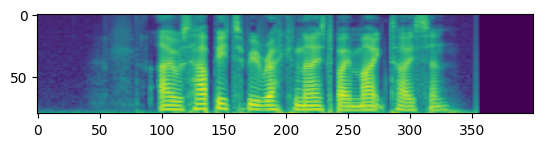

In [129]:
melspec = melspectrogram(torch.tensor(audio))
print(melspec.shape)
pixels = audio_utils.mel_img(melspec[0].detach().numpy(), cmap=cmap)
plt.imshow(pixels)
plt.show()

In [130]:
recon_audio = hfgan(melspec)
print(recon_audio.shape)
ipd.Audio(recon_audio.detach().numpy()[0],rate=16000)

torch.Size([4, 1, 64000])


#### Hyface pred

(80, 400, 3)


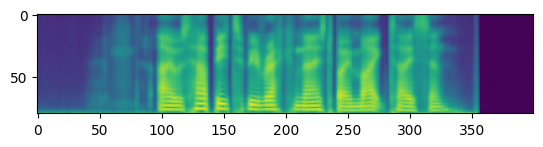

In [60]:
pixels = audio_utils.mel_img(mel_synth[0].detach().numpy(), cmap=cmap)
print(pixels.shape)
plt.imshow(pixels)
plt.show()

In [61]:
synth = hfgan(mel_synth)
print(synth.shape)
ipd.Audio(synth.detach().numpy()[0],rate=16000)

torch.Size([4, 1, 64000])


In [62]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [63]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [64]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [65]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [66]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

# BShall_Nimbre

In [71]:
# main_dir = '/home/jaejun/nansy/
config_path = '/disk3/jaejun/hyface/bshall_nimbre/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

# args.meta_root = '/disk3/jaejun/hyface/training'
# args.base_dir = '/disk3/jaejun/hyface/bshall/checkpoints'

In [72]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    hyface = BShall_Ecapa(args)

In [79]:
index = 3900
checkpoint_path = f'/disk3/jaejun/hyface/bshall_nimbre/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/disk3/jaejun/hyface/bshall_nimbre/checkpoints/G_3900.pth' (Epoch 3900)


## Normal test
Recon & VC test

In [80]:
# Waveform : vctk_f1, vctk_f2, vctk_m1, vctkm2
vctk_f1_ling = torch.load(vctk_f1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f2_ling = torch.load(vctk_f2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m1_ling = torch.load(vctk_m1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m2_ling = torch.load(vctk_m2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f1_timbre_global = torch.tensor(np.load(vctk_f1_path.replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
vctk_f1_timbre_bank = torch.tensor(np.load(vctk_f1_path.replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
vctk_f2_timbre_global = torch.tensor(np.load(vctk_f2_path.replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
vctk_f2_timbre_bank = torch.tensor(np.load(vctk_f2_path.replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
vctk_m1_timbre_global = torch.tensor(np.load(vctk_m1_path.replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
vctk_m1_timbre_bank = torch.tensor(np.load(vctk_m1_path.replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))
vctk_m2_timbre_global = torch.tensor(np.load(vctk_m2_path.replace('wav16_cleaned','nimbre_3000/timbre_global').replace('.wav','.emb.npy')))
vctk_m2_timbre_bank = torch.tensor(np.load(vctk_m2_path.replace('wav16_cleaned','nimbre_3000/timbre_bank').replace('.wav','.emb.npy')))

In [81]:
vctk_f1.shape

torch.Size([1, 32825])

In [82]:
a, b = hyface.analyze_timbre(vctk_f1.repeat(2,1))
print(a.shape, b.shape)

torch.Size([2, 192]) torch.Size([2, 128, 50])


In [83]:
f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).repeat(2,1,1).transpose(1,2), (a, b))
f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)


In [89]:
f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), (vctk_m1_nimbre_global_avg, vctk_m1_nimbre_bank_avg))
f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)


In [87]:
f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_f1_ecapa_avg)

f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)

ValueError: not enough values to unpack (expected 2, got 1)

In [71]:
timbre_global, timbre_bank = hyface.analyze_timbre(audio_tensor)
mel_synth = hyface.synthesize(ling_tensor, (timbre_global, timbre_bank))
mel_synth2 = hyface.synthesize(ling_tensor[0].unsqueeze(0).repeat(4, 1, 1), (timbre_global, timbre_bank))

In [72]:
synth = hfgan(mel_synth2)
print(synth.shape)

torch.Size([4, 1, 64000])


In [73]:
ipd.Audio(synth.detach().numpy()[0],rate=16000)

In [74]:
ipd.Audio(synth.detach().numpy()[1],rate=16000)

In [75]:
ipd.Audio(synth.detach().numpy()[2],rate=16000)

In [76]:
ipd.Audio(synth.detach().numpy()[3],rate=16000)

# BShall_Ecapa

In [30]:
# main_dir = '/home/jaejun/nansy/
config_path = '/disk3/jaejun/hyface/bshall_ecapa/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

# args.meta_root = '/home/jaejun/hyface/training'
# args.base_dir = '/home/jaejun/temp_jaejun/hyface/bshall_ecapa/checkpoints'

In [31]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    from speechbrain.pretrained import EncoderClassifier
    hyface = BShall_Ecapa(args)
    hyface.classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

/opt/conda/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [32]:
index = 2000
checkpoint_path = f'/disk3/jaejun/hyface/bshall_ecapa/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/disk3/jaejun/hyface/bshall_ecapa/checkpoints/G_2000.pth' (Epoch 2000)


## VCTK
Recon & VC test

In [119]:
# Waveform : vctk_f1, vctk_f2, vctk_m1, vctkm2
vctk_f1_ling = torch.load(vctk_f1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f2_ling = torch.load(vctk_f2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m1_ling = torch.load(vctk_m1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m2_ling = torch.load(vctk_m2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f1_timbre = hyface.analyze_timbre(vctk_f1)
vctk_f2_timbre = hyface.analyze_timbre(vctk_f2)
vctk_m1_timbre = hyface.analyze_timbre(vctk_m1)
vctk_m2_timbre = hyface.analyze_timbre(vctk_m2)

Recon

In [176]:
# f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_f1_timbre)
# this is by ecapa saved
# f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_f1_ecapas[3])
# this is by ecapa avg
f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_f1_ecapa_avg)
f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)

In [180]:
# f2_f2_mel = hyface.synthesize(vctk_f2_ling.unsqueeze(0).transpose(1,2), vctk_f2_timbre)
f2_f2_mel = hyface.synthesize(vctk_f2_ling.unsqueeze(0).transpose(1,2), vctk_f2_ecapa_avg)
f2_f2 = hfgan(f2_f2_mel)
ipd.Audio(f2_f2.detach().numpy()[0], rate=16000)

In [152]:
m1_m1_mel = hyface.synthesize(vctk_m1_ling.unsqueeze(0).transpose(1,2), vctk_m1_timbre)
m1_m1 = hfgan(m1_m1_mel)
ipd.Audio(m1_m1.detach().numpy()[0], rate=16000)

In [153]:
m2_m2_mel = hyface.synthesize(vctk_m2_ling.unsqueeze(0).transpose(1,2), vctk_m2_timbre)
m2_m2 = hfgan(m2_m2_mel)
ipd.Audio(m2_m2.detach().numpy()[0], rate=16000)

In [149]:
# VoxCeleb
f1_f1_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vox_m1_ecapa)
f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)

Conversion \
=> Conversion 잘 되고, speaker emb average 한 걸로 해도 잘된다 (더잘되는느낌?)

In [186]:
f1_m2_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_m2_ecapa_avg)
f1_m2 = hfgan(f1_m2_mel)
ipd.Audio(f1_m2.detach().numpy()[0], rate=16000)

In [187]:
m2_f2_mel = hyface.synthesize(vctk_m2_ling.unsqueeze(0).transpose(1,2), vctk_f2_ecapa_avg)
m2_f2 = hfgan(m2_f2_mel)
ipd.Audio(m2_f2.detach().numpy()[0], rate=16000)

## VoxCeleb2

In [19]:
hubert = torch.hub.load("bshall/hubert:main", "hubert_soft", trust_repo=True).cuda()

Using cache found in /root/.cache/torch/hub/bshall_hubert_main


In [40]:
vox_m1_ling = hubert.units(vox_m1.unsqueeze(0).cuda()).detach().cpu()
vox_m2_ling = hubert.units(vox_m2.unsqueeze(0).cuda()).detach().cpu()
vox_f1_ling = hubert.units(vox_f1.unsqueeze(0).cuda()).detach().cpu()
vox_f2_ling = hubert.units(vox_f2.unsqueeze(0).cuda()).detach().cpu()
print(f'm1 ling:{vox_m1_ling.shape}, timbre:{vox_m1_ecapa.shape}')
print(f'm2 ling:{vox_m2_ling.shape}, timbre:{vox_m2_ecapa.shape}')
print(f'f1 ling:{vox_f1_ling.shape}, timbre:{vox_f1_ecapa.shape}')
print(f'f2 ling:{vox_f2_ling.shape}, timbre:{vox_f2_ecapa.shape}')

m1 ling:torch.Size([1, 252, 256]), timbre:torch.Size([1, 192])
m2 ling:torch.Size([1, 1104, 256]), timbre:torch.Size([1, 192])
f1 ling:torch.Size([1, 438, 256]), timbre:torch.Size([1, 192])
f2 ling:torch.Size([1, 233, 256]), timbre:torch.Size([1, 192])


In [41]:
m1_m1_mel = hyface.synthesize(vox_m1_ling.transpose(1,2), vox_m1_ecapa)
m1_m1 = hfgan(m1_m1_mel)
ipd.Audio(m1_m1.detach().numpy()[0], rate=16000)

In [42]:
m2_m2_mel = hyface.synthesize(vox_m2_ling.transpose(1,2), vox_m2_ecapa)
m2_m2 = hfgan(m2_m2_mel)
ipd.Audio(m2_m2.detach().numpy()[0], rate=16000)

In [45]:
f1_f1_mel = hyface.synthesize(vox_f1_ling.transpose(1,2), vox_f1_ecapa)
f1_f1 = hfgan(f1_f1_mel)
ipd.Audio(f1_f1.detach().numpy()[0], rate=16000)

In [46]:
f2_f2_mel = hyface.synthesize(vox_f2_ling.transpose(1,2), vox_f2_ecapa)
f2_f2 = hfgan(f2_f2_mel)
ipd.Audio(f2_f2.detach().numpy()[0], rate=16000)

In [49]:
f1_m2_mel = hyface.synthesize(vox_f1_ling.transpose(1,2), vox_m2_ecapa)
f1_m2 = hfgan(f1_m2_mel)
ipd.Audio(f1_m2.detach().numpy()[0], rate=16000)

# BShall_Ecapa (Bshall ac pretrained)

In [196]:
# main_dir = '/home/jaejun/nansy/
config_path = '/disk3/jaejun/hyface/bshall_pretrained_ecapa/logs/config.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

In [197]:
if args.model.generator == "nansy":
    hyface = Nansy(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "nansy":
    hyface = BShall_Nimbre(args)
elif args.model.generator == "bshall" and args.model.timbre.type == "ecapa":
    from speechbrain.pretrained import EncoderClassifier
    hyface = BShall_Ecapa(args)
    hyface.classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

Using cache found in /root/.cache/torch/hub/bshall_acoustic-model_main


Param proj.weight is not in the checkpoint


In [198]:
index = 3000
checkpoint_path = f'/disk3/jaejun/hyface/bshall_pretrained_ecapa/checkpoints/G_{index}.pth'
hyface, _, _, _ = utils.load_checkpoint(checkpoint_path, hyface, None)

Loaded checkpoint '/disk3/jaejun/hyface/bshall_pretrained_ecapa/checkpoints/G_3000.pth' (Epoch 3000)


## Normal test
Recon & VC test

In [202]:
# Waveform : vctk_f1, vctk_f2, vctk_m1, vctkm2
vctk_f1_ling = torch.load(vctk_f1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f2_ling = torch.load(vctk_f2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m1_ling = torch.load(vctk_m1_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_m2_ling = torch.load(vctk_m2_path.replace('wav16_cleaned','hubert_soft').replace('.wav','.emb'))
vctk_f1_timbre = hyface.analyze_timbre(vctk_f1)
vctk_f2_timbre = hyface.analyze_timbre(vctk_f2)
vctk_m1_timbre = hyface.analyze_timbre(vctk_m1)
vctk_m2_timbre = hyface.analyze_timbre(vctk_m2)

Conversion \
=> Conversion 잘 되고, speaker emb average 한 걸로 해도 잘된다 (더잘되는느낌?)

In [203]:
f1_m2_mel = hyface.synthesize(vctk_f1_ling.unsqueeze(0).transpose(1,2), vctk_m2_ecapa_avg)
f1_m2 = hfgan(f1_m2_mel)
ipd.Audio(f1_m2.detach().numpy()[0], rate=16000)

In [204]:
m2_f2_mel = hyface.synthesize(vctk_m2_ling.unsqueeze(0).transpose(1,2), vctk_f2_ecapa_avg)
m2_f2 = hfgan(m2_f2_mel)
ipd.Audio(m2_f2.detach().numpy()[0], rate=16000)

### this is for temp

In [125]:
test_dir = "/data2/VoxCeleb2/test"
spkrs = os.listdir(test_dir)

In [126]:
cnt = 0
for spkr in spkrs:
    cnt += len(os.listdir(os.path.join(mother_dir, spkr)))
print(len(spkrs), cnt)

118 36237


In [127]:
train_dir = "/data2/VoxCeleb2/dev"
spkrs = os.listdir(train_dir)

In [128]:
cnt = 0
for spkr in spkrs:
    cnt += len(os.listdir(os.path.join(train_dir, spkr)))
print(len(spkrs), cnt)

5994 1092009
